<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Laura/AML_IceCores_last_hidden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Ins

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

In [6]:
x_train.shape

(10000, 128, 128)

In [7]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 11s 33ms/step - loss: 0.0305 - val_loss: 0.0126
Epoch 2/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0092 - val_loss: 0.0076
Epoch 3/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 4/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/200
282/282 [==============================] - 9s 32ms/step - loss: 0.00

In [9]:
#encoder.save('encoder')

In [10]:
#y_preds = encoder.predict(x_train)

In [11]:
#map = umap.UMAP(n_components=2)
#y = map.fit_transform(y_preds)

In [12]:
#plt.figure()
#sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
#plt.show()

In [13]:
#input_length = len(x_train_feats[0]) + latent_dim

#dense_input = keras.Input(shape=(input_length))
#x = keras.layers.Dense(128, activation='relu')(dense_input)
#x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
#x = keras.layers.Dense(128*2, activation='relu')(x)
#x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
#x = keras.layers.Dense(128, activation='relu')(x)
#x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
#dense_output = keras.layers.Dense(7, activation='softmax')(x)

#dense_model = keras.Model(dense_input, dense_output, name='dense_model')

#dense_model.summary()

#opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

#dense_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [14]:
#x_train_with_encoded = []
#for i in range(len(y_preds)):
#    inp = np.append(x_train_feats[i], y_preds[i])
#    x_train_with_encoded.append(inp)
#x_train_with_encoded = np.array(x_train_with_encoded)

In [15]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

#for i in range(5):
#  # create encoder training
#  nr_tot_images = len(sup.labels)
#  x_train = []
#  x_train_lab = []
#  x_train_feats = []
#  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
#  rand_idx = np.arange(0,nr_tot_images)
#  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
#  for i in range(nr_ims):
#      im, lab, feat = sup.__getitem__(rand_idx[i])
#      x_train.append(im)
#      x_train_lab.append(lab)
#      x_train_feats.append(feat)
#  x_train = np.array(x_train)
#  x_train_lab = np.array(x_train_lab)
#  x_train_feats = np.array(x_train_feats)

 # y_preds = encoder.predict(x_train)

#  x_train_with_encoded = []
#  for i in range(len(y_preds)):
#      inp = np.append(x_train_feats[i], y_preds[i])
#      x_train_with_encoded.append(inp)
#  x_train_with_encoded = np.array(x_train_with_encoded)

#  dense_model.fit(x_train_with_encoded, x_train_lab, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

In [16]:
#dense_model.save('dense_model')

tree = lgb.LGBMClassifier(objective='multiclass')

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)

# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)

x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

In [17]:
#y_pred = tree.predict(x_train_with_encoded)

In [18]:
#sum(y_pred==x_train_lab)/len(y_pred)

# Få det sidste lag ud:


In [25]:
input_length = len(x_train_feats[0]) + latent_dim
dim_last_hidden = 128

dense_input = keras.Input(shape=(input_length))
x = keras.layers.Dense(128, activation='relu')(dense_input)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
x = keras.layers.Dense(128*2, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
last_hidden = keras.layers.Dense(dim_last_hidden, activation='relu')(x)


dense2_input = keras.layers.InputLayer(input_shape=dim_last_hidden)(last_hidden)
x = keras.layers.Dropout(0.2)(dense2_input)
x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
dense_output = keras.layers.Dense(7, activation='softmax')(x)

last_hidden_model = keras.Model(dense_input, last_hidden, name='mellem_model')
dense_model = keras.Model(dense_input, dense_output, name='dense_model')

dense_model.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

last_hidden_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
dense_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_6 (Dense)             (None, 128)               12672     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
n_epochs = 200
batch_size = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, min_delta = 0.0001)

encode_scalars = np.concatenate((encoder.predict(x_train),x_train_feats), axis=1)

history = dense_model.fit(encode_scalars,x_train_lab,validation_split=0.2,batch_size=batch_size, epochs= n_epochs, callbacks=[callback])

Epoch 1/200
400/400 [==============================] - 3s 4ms/step - loss: 1.0512 - accuracy: 0.6457 - val_loss: 0.6761 - val_accuracy: 0.7630
Epoch 2/200
400/400 [==============================] - 2s 4ms/step - loss: 0.7553 - accuracy: 0.7304 - val_loss: 0.5794 - val_accuracy: 0.7815
Epoch 3/200
400/400 [==============================] - 2s 4ms/step - loss: 0.6778 - accuracy: 0.7588 - val_loss: 0.5292 - val_accuracy: 0.8060
Epoch 4/200
400/400 [==============================] - 2s 4ms/step - loss: 0.6292 - accuracy: 0.7729 - val_loss: 0.5323 - val_accuracy: 0.8080
Epoch 5/200
400/400 [==============================] - 2s 4ms/step - loss: 0.5897 - accuracy: 0.7839 - val_loss: 0.5386 - val_accuracy: 0.7960
Epoch 6/200
400/400 [==============================] - 2s 4ms/step - loss: 0.5832 - accuracy: 0.7851 - val_loss: 0.5015 - val_accuracy: 0.8160
Epoch 7/200
400/400 [==============================] - 2s 4ms/step - loss: 0.5589 - accuracy: 0.7936 - val_loss: 0.4939 - val_accuracy: 0.8145

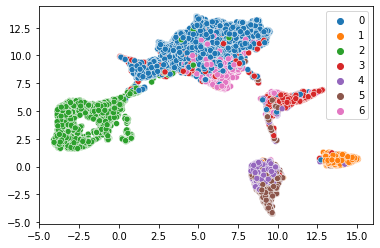

In [27]:
y_last_hid = last_hidden_model.predict(encode_scalars)

map = umap.UMAP(n_components=2) #x and y axis
y = map.fit_transform(y_last_hid)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab, palette = 'tab10')
plt.show()